# Использование [ансамблевых моделей](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D1%8C_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%B2_(%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD)) (или композиции моделей)

Идея использования ансамблевых моделей состоит в том, что оценивается результат совместного голосования различных моделей. Идеи объединения моделей в ансамбль могут быть различными. 

Использование ансамблевых моделей поддерживается в [scikit-learn.](https://scikit-learn.org/stable/modules/ensemble.html)

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

Вспомним, что в соответствии с [дилеммой смещения–дисперсии](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%BB%D0%B5%D0%BC%D0%BC%D0%B0_%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D1%8F%E2%80%93%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D0%B8) невозможно одновременно улучшить и смещение и дисперсию модели.

Поэтому некоторые ансамблевые классификаторы ориентированы на уменьшение дисперсии, а некоторые на уменьшение смещения.

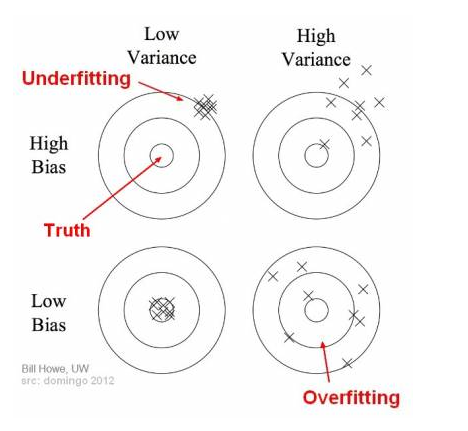

In [2]:
Image('img/bv1.png', width='50%')

## Бутстрэп

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $X$ размера $N$. Равномерно возьмем из выборки $N$ объектов с возвращением. Это означает, что мы будем $N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $X_1$. Повторяя процедуру K раз, сгенерируем K подвыборок $X_1$ ... $X_K$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

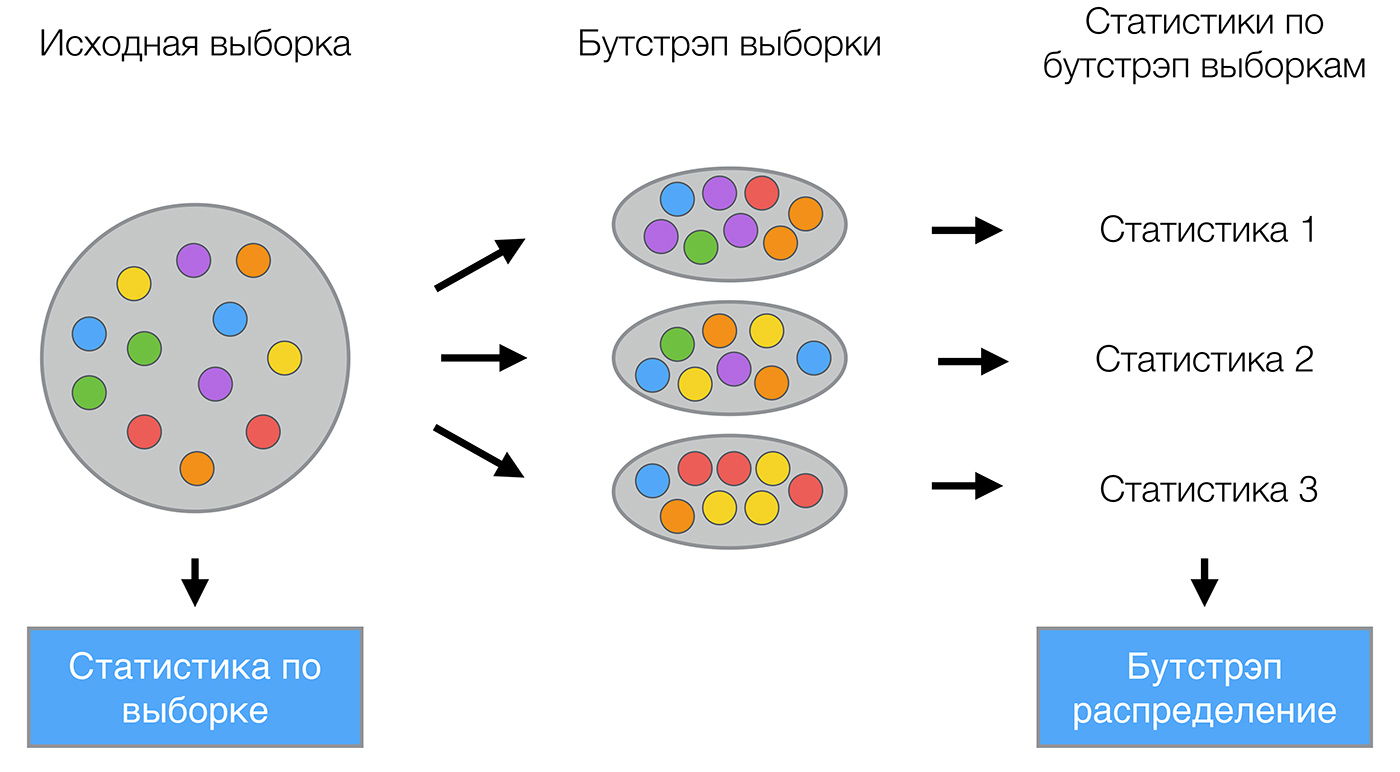

In [3]:
Image("img/bootstrap.jpg")

## Бэггинг

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман Лео Брейманом в 1994 году. Бэггинг основан на статистическом методе бутстрэпа.

Пусть имеется обучающая выборка $X$ размера $N$. С помощью бутстрэпа сгенерируем из этой выборки $K$ подвыборок $X_1$ ... $X_K$. Теперь на каждой выборке обучим свою модель $M_i(x)$. Итоговый классификатор будет усреднять ответы всех моделей (выбирать средний результат голосования): $M(x) = \frac{1}{K} \sum\limits_{i=1}^K M_i(x)$

Бэггинг позволяет **снизить дисперсию (variance)** обучаемого классификатора, уменьшая величину, на которую ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

**Важно** то что модель бэггинга строится на ансамбле **разных** обучающих выборок, но **одинаковых** моделей.

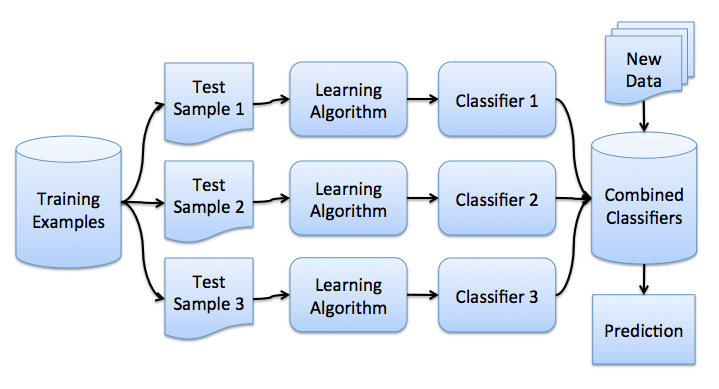

In [4]:
Image("img/bagging.png")

### Out-of-bag error

В моделях на основе бэггинга (в том числе, случайный лес) нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Посмотрим, как получается "внутренняя" оценка модели во время ее обучения.

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева. 

Это можно легко доказать: пусть в выборке $N$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект попадают в подвыборку с вероятностью $\frac{1}{N}$. Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $N$ раз): $(1-\frac{1}{N})^N$. При $N$ стремящемся к бесконечности получаем второй "замечательный" предел, значение которого $\frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку приближенно равна $1-\frac{1}{e}$ что составляет около 63%. Таким образом, примерно 100%-63%=37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.

Метод бэггинга реализуется в scikit-learn с помощью классов [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) и [BaggingRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)

In [5]:
# Используем датасет iris с двумя первыми признаками
iris = load_iris()
iris_X = iris.data[:, :2]
iris_y = iris.target

In [6]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [7]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(15,7)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

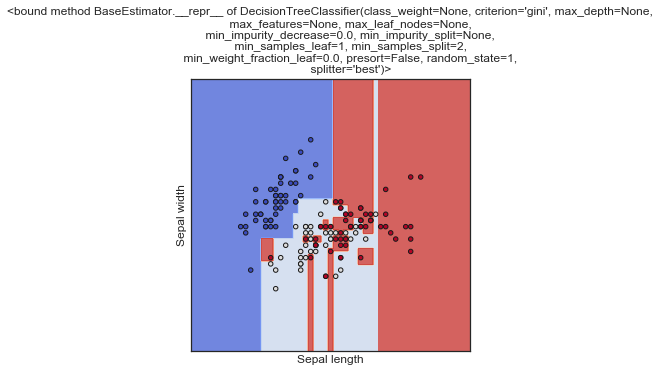

In [8]:
plot_cl(DecisionTreeClassifier(random_state=1))

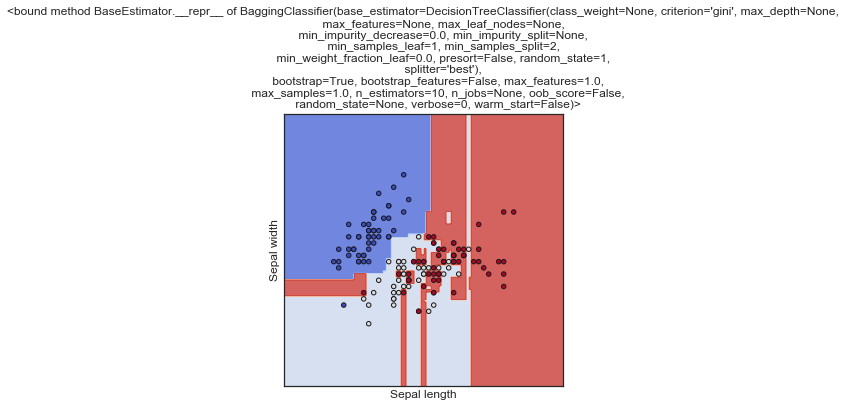

In [9]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1)))

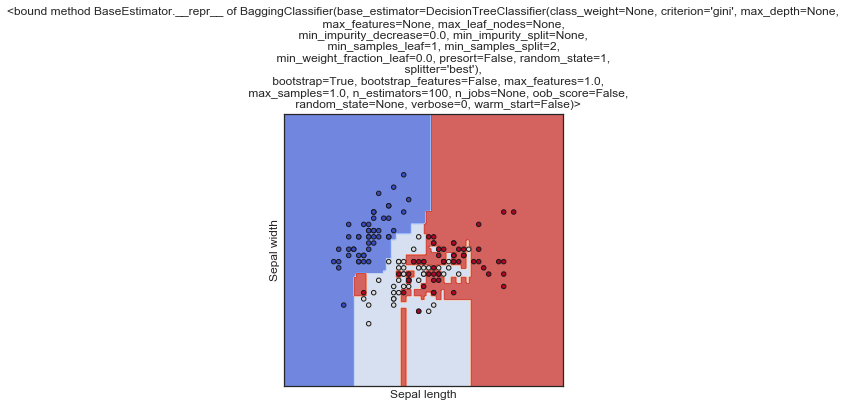

In [10]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=100))

## [Случайный лес](https://ru.wikipedia.org/wiki/Random_forest)

Алгоритм случайного леса также предложен Лео Брейманом. Алгоритм сочетает в себе две основные идеи: метод бэггинга, предложенный Лео Брейманом, и метод случайных подпространств, предложенный Tin Kam Ho. 

Случайный лес можно рассматривать как алгоритмом бэггинга над решающими деревьями. 

Но при этом каждое решающее дерево строится на случайно выбранном подмножестве признаков. Эта особенность называется "feature bagging" и основана на [методе случайных подпространств](https://en.wikipedia.org/wiki/Random_subspace_method).

Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на случайно выбранных подмножествах признаков. Ансамбль моделей, использующих метод случайного подпространства, можно построить, используя следующий алгоритм:

1. Пусть количество объектов для обучения равно $N$, а количество признаков $D$.
1. Выбирается число отдельных моделей в ансамбле $L$.
1. Для каждой отдельной модели $l = 1..L$ выбирается число признаков $dl (dl < D)$. Как правило, для всех моделей используется только одно значение
$dl$.
1. Для каждой отдельной модели $l$ создается обучающая выборка путем отбора $dl$ признаков из $D$.
1. Производится обучение моделей $l = 1..L$, каждая модель обучается на отдельном подмножестве из $dl$ признаков.
1. Чтобы применить модель ансамбля к тестовой выборке, объединяются результаты отдельных моделей или мажоритарным голосованием или более сложными способами.

Почему именно деревья активно используются в ансамблевых моделях? Потому что они очень чувствительны к выбросам и изменению данных. Незначительное изменение обучающей выборки, удаление или добавление признаков может сильно изменить вид решающего дерева. Это является недостатком с точки зрения построения отдельного решающего дерева. Это же является преимуществом при использовании деревьев в ансамблевой модели, так как с помощью незначительного изменения обучающих данных или набора используемых признаков можно построить очень разные решающие деревья. Различные решающие деревья дадут хорошую "дисперсию" решений при объединении их в ансамбль.

### Принцип построения случайного леса:

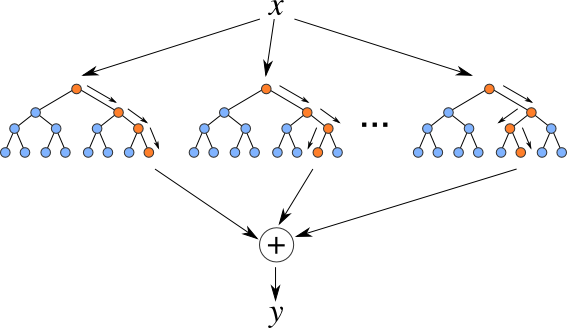

In [11]:
Image("img/rf.png")

### Алгоритм построения случайного леса

- Пусть количество объектов для обучения равно $N$, а количество признаков $D$.
- Выбирается число отдельных деревьев в ансамбле (случайном лесе) $L$. Для каждого отдельного дерева $tree_i = 1..L$ выбирается число признаков $dl (dl < D)$ для последующего случайного разбиения. Как правило, для всех моделей используется только одно значение $dl$.
- Для каждого дерева с индексом $i=1..L$ выполняются следующие действия:
    - Генерируется выборка $X_i$ с помощью бутстрэпа
    - Строится решающее дерево $tree_i$ по выборке $X_i$:
        - По заданному критерию выбирается лучший признак для ветвления дерева, делается ветвление в дереве по выбранному признаку и так до исчерпания выборки. В качестве критерия может использоваться критерий Джини или энтропийный критерий.
        - Дерево строится до тех пор, пока в каждом листе не более $leaf_{min}$ объектов или пока не будет достигнута определенная высота дерева.
        - При каждом разбиении сначала выбирается $dl$ случайных признаков из $D$ исходных, и оптимальное разделение выборки ищется только среди них.

- Итоговая модель $RandomForest(X) = \frac{1}{L} \sum\limits_{i=1}^L tree_i(X)$. То есть для задачи кассификации выбирается решение голосованием по большинству, а в задаче регрессии — среднее значение.

Таким образом, случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

Рекомендуется в задачах классификации брать $dl=\sqrt{D}$, а в задачах регрессии $dl = D/3$. В библиотеке scikit-learn это признак max_features.

Для выбора параметра $leaf_{min}$ рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять объектов. В библиотеке scikit-learn это признак min_samples_leaf.

Настройка гиперпараметров случайного леса хорошо описана в [блоге Александра Дьяконова.](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/comment-page-1/)

Алгоритм случайного леса активно применяется на практике и часто оказывается лучшим при сравнении метрик качества.

Случайный лес реализуется в scikit-learn с помощью классов [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) и [RandomForestRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

### Сверхслучайные деревья

В сверхслучайных деревьях (Extremely Randomized Trees) больше случайности в том, как вычисляются разделения в узлах. Как и в случайных лесах, используется случайное подмножество возможных признаков, но вместо поиска  оптимальных порогов, пороговые значения произвольно выбираются для каждого возможного признака, и наилучший из этих случайно генерируемых порогов выбирается как лучшее правило для разделения узла. Это обычно позволяет немного уменьшить дисперсию модели за счет несколько большего увеличения смещения.

Данный метод следует использовать при сильном переобучении на случайном лесе или градиентном бустинге. 

Сверхслучайные деревья реализуется в scikit-learn с помощью классов  [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) и [ExtraTreesRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor) 

### Эксперименты:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


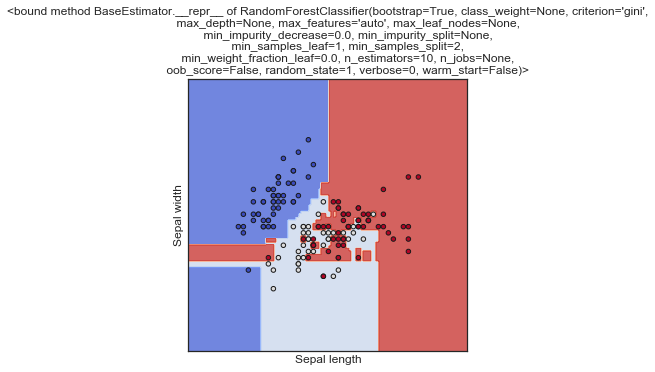

In [12]:
plot_cl(RandomForestClassifier(random_state=1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


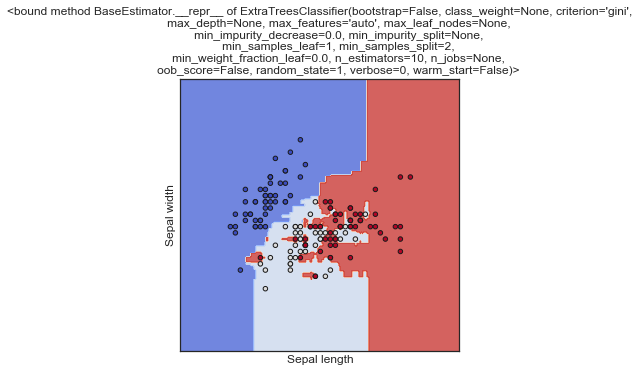

In [13]:
plot_cl(ExtraTreesClassifier(random_state=1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


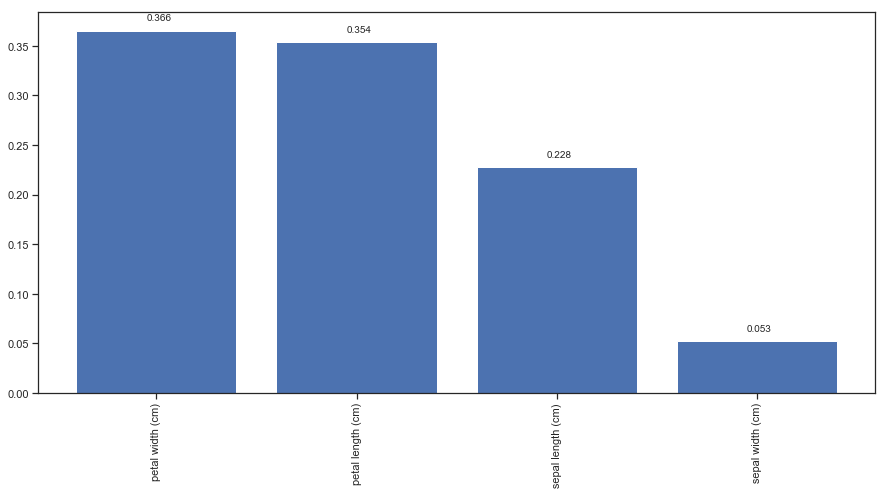

In [14]:
# Важность признаков
iris_x_ds = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_rf_cl = RandomForestClassifier(random_state=1)
iris_rf_cl.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(iris_rf_cl, iris_x_ds)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


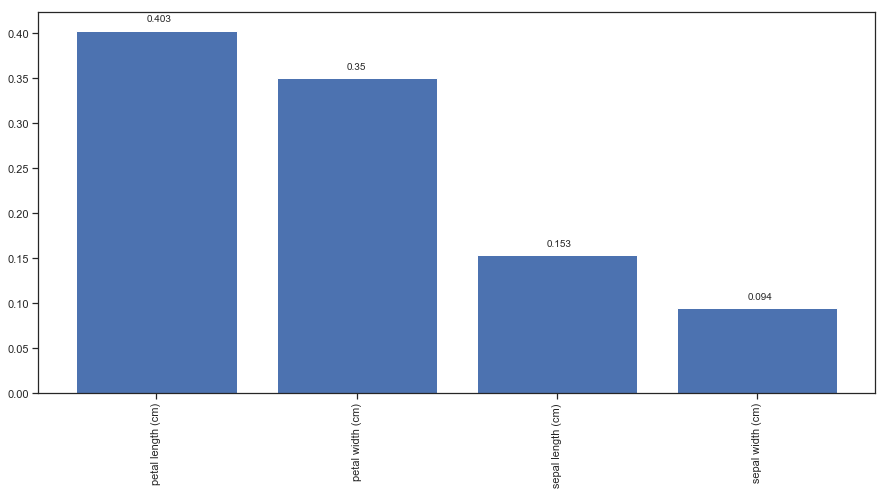

In [15]:
iris_xtree_cl = ExtraTreesClassifier(random_state=1)
iris_xtree_cl.fit(iris_x_ds, iris.target)
_, _ = draw_feature_importances(iris_xtree_cl, iris_x_ds)

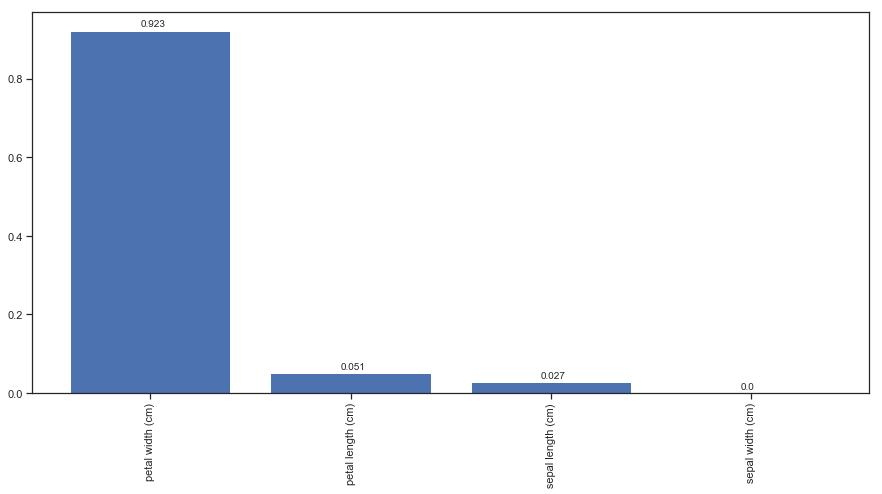

In [16]:
iris_tree_cl = DecisionTreeClassifier(random_state=1)
iris_tree_cl.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(iris_tree_cl, iris_x_ds)

## [Бустинг](https://ru.wikipedia.org/wiki/%D0%91%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3_(%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD))

Идея бустинга состоит в том, что строится многослойная модель (классификации или регрессии) и каждый следующий слой пытается минимизировать ошибку, допущенную на предыдущем слое.

В отличие от методов бэггинга, которые **ориентированы на минимизизацию дисперсии (Variance)**, методы бустинга **ориентированы на минимизацию смещения (Bias)**.

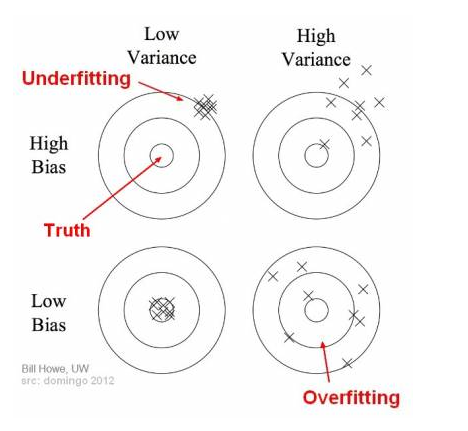

In [17]:
Image('img/bv1.png', width='50%')

Идея метода отчасти напоминает идею нейронной сети, но в качестве "нейрона" обычно используется решающее дерево (хотя может использоваться произвольная модель).

Различие между бэггингом и бустингом показано на следющем рисунке:

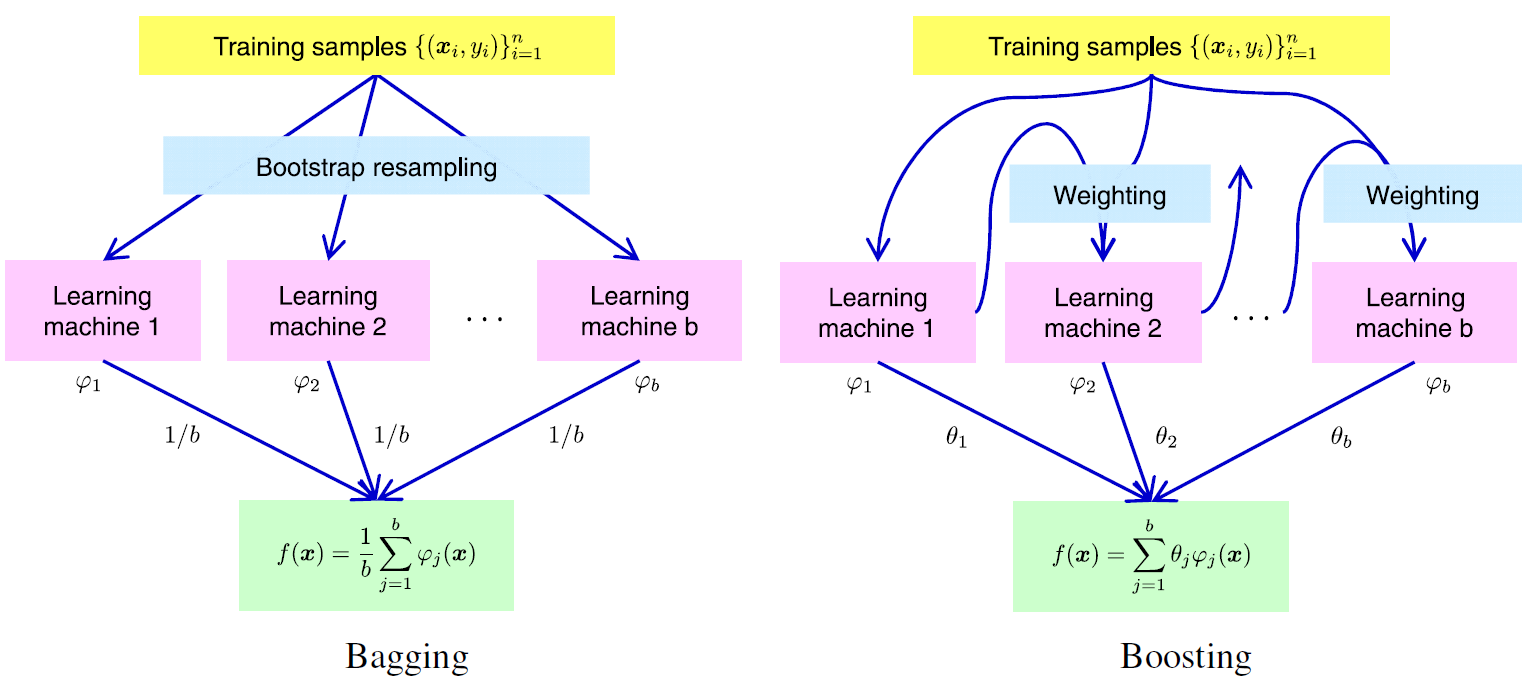

In [18]:
Image("img/boosting.png", width="800")

### Алгоритм AdaBoost

Исторически первым полноценным алгоритмом бустинга считается алгоритм [AdaBoost.](https://ru.wikipedia.org/wiki/AdaBoost) 

[Статья авторов с пояснением метода.](http://www.site.uottawa.ca/~stan/csi5387/boost-tut-ppr.pdf)

[Презентация](https://mycourses.aalto.fi/pluginfile.php/901916/mod_folder/content/0/Boosting.pdf) с пояснением работы метода ([локальная копия](materials/boosting.pdf)). 

AdaBoost реализуется в scikit-learn с помощью классов [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) и [AdaBoostRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

В настоящее время алгоритм AdaBoost считается устаревшим и вместо него используется:

### Алгоритм [градиентного бустинга](https://en.wikipedia.org/wiki/Gradient_boosting)

[Краткое введение в градиентный бустинг.](https://neurohive.io/ru/osnovy-data-science/gradientyj-busting/)

[Блог Александра Дьяконова. Градиентный бустинг](https://dyakonov.org/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)

Основные принципы градиентного бустинга изложены в [математическом описании реализации scikit-learn.](https://scikit-learn.org/stable/modules/ensemble.html#mathematical-formulation)

#### Реализации градиентного бустинга

Рассмотрены в статьях:
- https://medium.com/diogo-menezes-borges/boosting-with-adaboost-and-gradient-boosting-9cbab2a1af81
- https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

Градиентный бустинг реализуется в scikit-learn с помощью классов [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) и [GradientBoostingRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) Но эта реализация считается неэффективной.

Традиционно вместо нее использовалась библиотека [XGBoost.](https://github.com/dmlc/xgboost)

В последнее время также активно используется библиотека [LightGBM.](https://github.com/Microsoft/LightGBM) Статья о [настройке гиперпараметров.](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

Наиболее новой и перспективной является библиотека от Яндекса [CatBoost.](https://tech.yandex.ru/catboost/)

#### Эксперименты с реализацией scikit-learn:

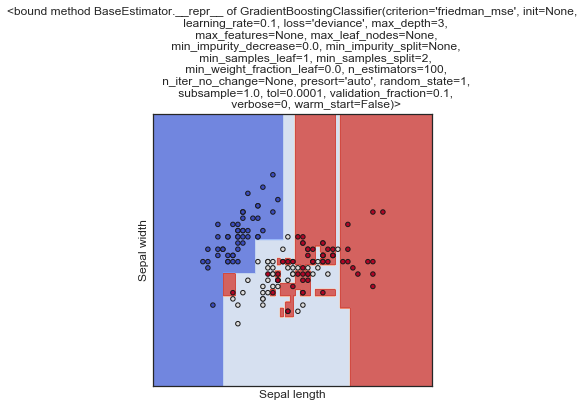

In [19]:
plot_cl(GradientBoostingClassifier(random_state=1))

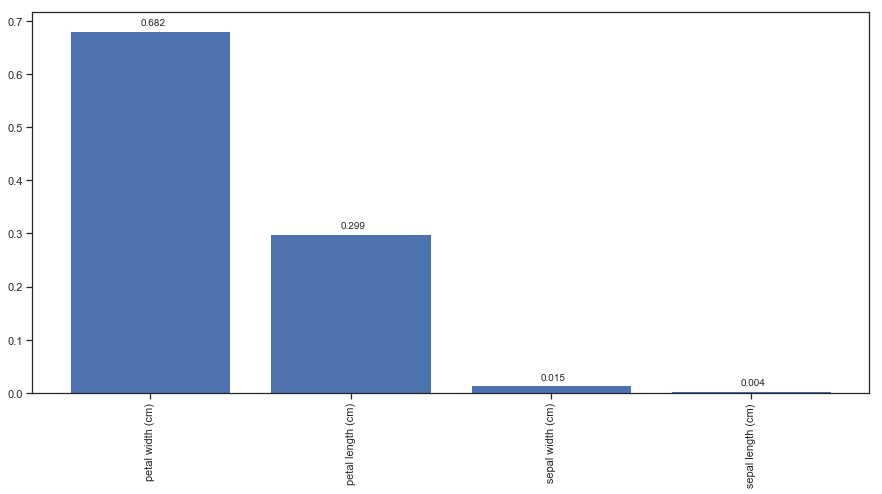

In [20]:
# Важность признаков
iris_gb_cl = GradientBoostingClassifier(random_state=1)
iris_gb_cl.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(iris_gb_cl, iris_x_ds)

## [Стекинг](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking)

Концепция стекинга очень детально рассмотрена в [блоге Александра Дьяконова](https://dyakonov.org/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/)

Идея стекинга показана на следующем рисунке:

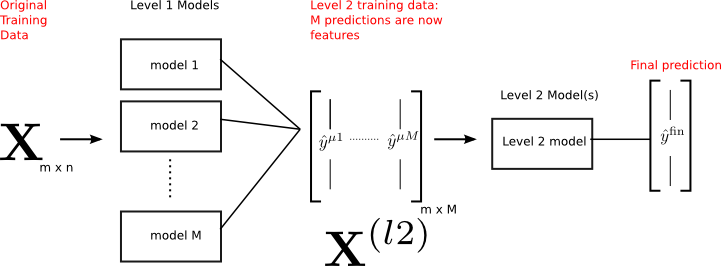

In [21]:
Image("img/stacking.png")

В scikit-learn данная модель не реализована напрямую. Она реализована в библиотеке [heamy.](https://heamy.readthedocs.io/en/latest/)

In [22]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [23]:
boston = load_boston()
boston_X, boston_y = boston['data'], boston['target']
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(
    boston_X, boston_y, test_size=0.2, random_state=1)

In [24]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(boston_X_train, boston_y_train)
    y_pred = model.predict(boston_X_test)
    result = mean_absolute_error(boston_y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))

In [25]:
val_mae(LinearRegression())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
MAE=3.7507121808389168


In [26]:
val_mae(DecisionTreeRegressor())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
MAE=3.0274509803921568


In [27]:
val_mae(RandomForestRegressor(n_estimators=50))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE=2.39143137254902


In [28]:
# набор данных
dataset = Dataset(boston_X_train, boston_y_train, boston_X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [29]:
# Stacking двух моделей
pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)

# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
#results = stacker.predict()
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.318965416602871, 2.4728390293622438, 2.4800209549800587, 3.0588974018602935, 3.022938328410697, 2.728429106107528, 3.007973419640338, 2.0076189055826985, 2.6823423168515492, 3.107194257018803]
Mean accuracy: 2.688721913641708
Standard Deviation: 0.3490230902364646
Variance: 0.12181711751821131


In [30]:
# модель второго уровня - более точная
stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.417073170731707, 2.342682926829268, 2.674390243902439, 3.261463414634146, 2.528249999999999, 2.6225, 2.7482499999999996, 2.8279999999999994, 2.8309999999999995, 2.6654999999999993]
Mean accuracy: 2.6919109756097557
Standard Deviation: 0.24403553202828074
Variance: 0.059553340892326036


In [31]:
# Stacking трех моделей
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)

# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [1.666287921077175, 2.2175301691787235, 2.105832079935589, 3.0527828020850554, 2.456036908874142, 2.1750677247238595, 2.4819957910220998, 2.2067728421911896, 2.186947822545759, 2.2704455892934283]
Mean accuracy: 2.281969965092702
Standard Deviation: 0.3324076109141996
Variance: 0.11049481979368592


In [32]:
# модель второго уровня - более точная - результат ухудшился
stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [1.8429268292682917, 2.6141463414634147, 2.433170731707317, 3.3209756097560983, 2.70075, 2.5740000000000007, 2.3964999999999996, 2.578500000000001, 2.1725000000000003, 2.5805]
Mean accuracy: 2.5213969512195122
Standard Deviation: 0.3598681576862468
Variance: 0.1295050909164934


## [Метод группового учета аргументов](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%BE%D0%B2%D0%BE%D0%B3%D0%BE_%D1%83%D1%87%D1%91%D1%82%D0%B0_%D0%B0%D1%80%D0%B3%D1%83%D0%BC%D0%B5%D0%BD%D1%82%D0%BE%D0%B2)

Англ. [Group method of data handling](https://en.wikipedia.org/wiki/Group_method_of_data_handling) (GMDH).

Избретен в СССР академиком [А.Г.Ивахненко.](https://ru.wikipedia.org/wiki/%D0%98%D0%B2%D0%B0%D1%85%D0%BD%D0%B5%D0%BD%D0%BA%D0%BE,_%D0%90%D0%BB%D0%B5%D0%BA%D1%81%D0%B5%D0%B9_%D0%93%D1%80%D0%B8%D0%B3%D0%BE%D1%80%D1%8C%D0%B5%D0%B2%D0%B8%D1%87)

[Презентация](http://www.machinelearning.ru/wiki/images/6/65/DM_L3-2_part1.pdf) с детальным описанием работы метода.

Краткая идея метода заключается в том, что метод напоминает глубокую нейронную сеть. Но слои нейронной сети выращиваются с помощью эволюционных методов (разновидностей генетического алгоритма) до тех пор пока растет качество модели и еще не наступает переобучение.

Идея МГУА показана на следующем рисунке:

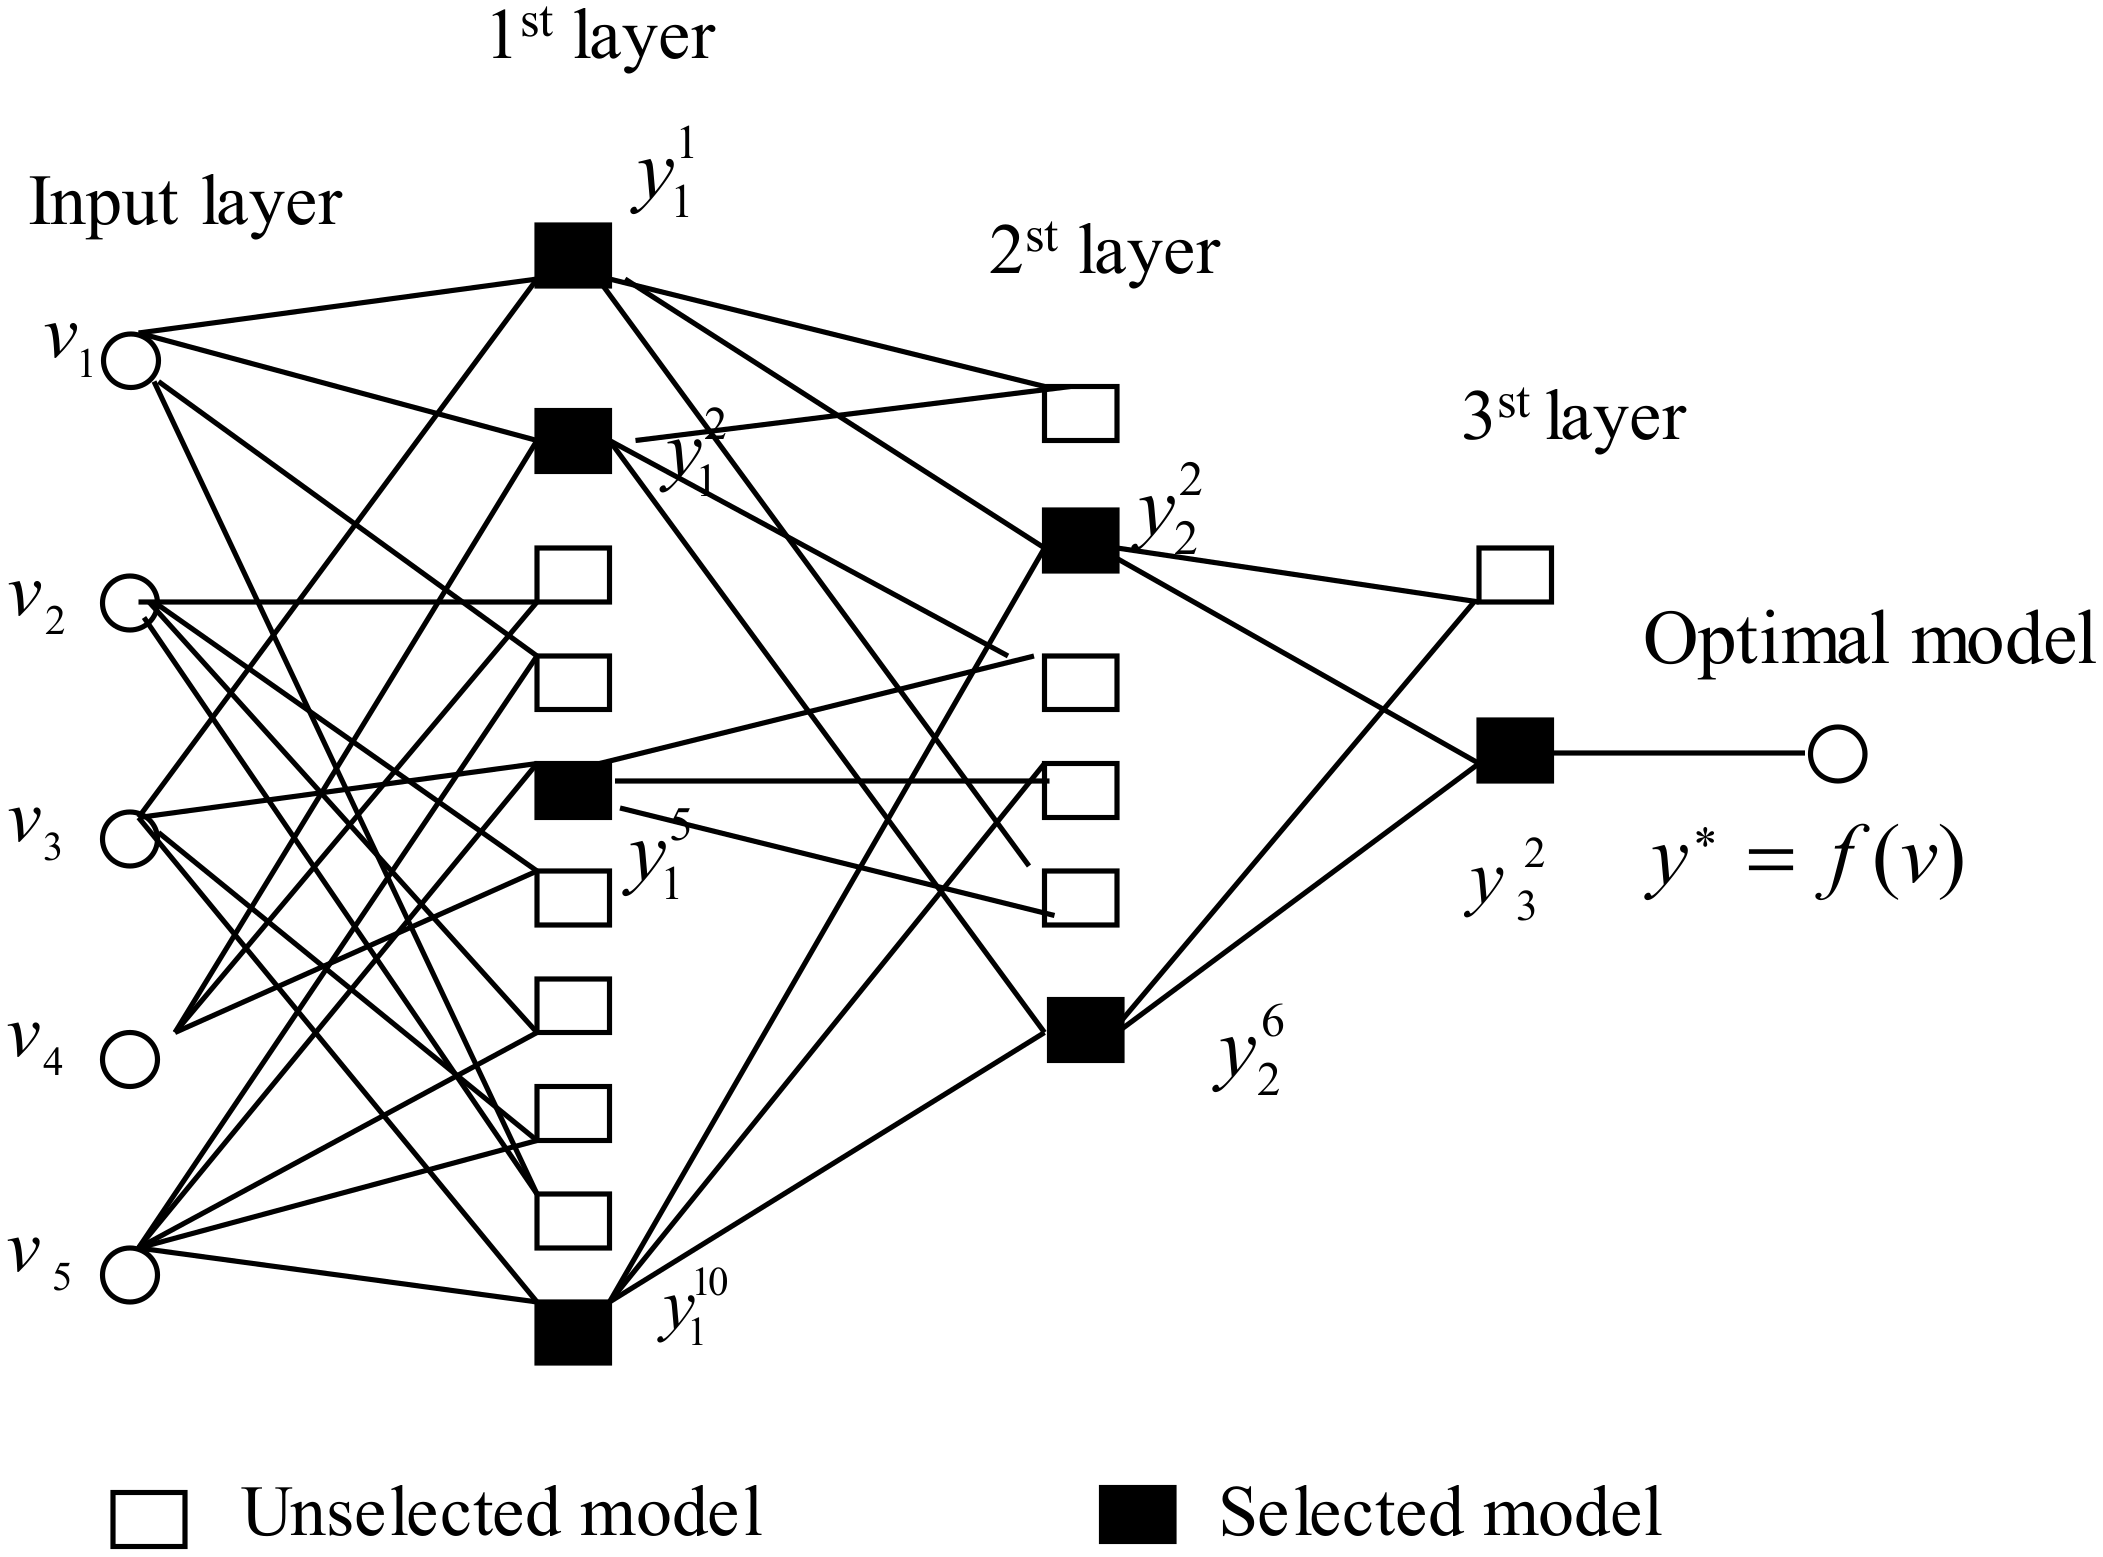

In [33]:
Image('img/gmdh.png', width='50%')

В scikit-learn данная модель не реализована напрямую. Она реализована в библиотеке [GmdhPy.](https://github.com/kvoyager/GmdhPy)

In [34]:
from gmdhpy import gmdh 

In [35]:
model = gmdh.Regressor()
model.fit(boston_X_train, boston_y_train)
y_pred = model.predict(boston_X_test)
result = mean_absolute_error(boston_y_test, y_pred)
print(model)
print('MAE={}'.format(result))

train layer0 in 0.06 sec
train layer1 in 0.21 sec
train layer2 in 0.23 sec
train layer3 in 0.21 sec
train layer4 in 0.21 sec
train layer5 in 0.22 sec
train layer6 in 0.21 sec
train layer7 in 0.21 sec
train layer8 in 0.21 sec
train layer9 in 0.21 sec
Self-organizing deep learning polynomial neural network
MAE=3.2568485867598214


In [36]:
model = gmdh.Regressor(ref_functions=('linear_cov', 'quadratic', 'cubic', 'linear'))
model.fit(boston_X_train, boston_y_train, validation_data=(boston_X_test, boston_y_test))
y_pred = model.predict(boston_X_test)
result = mean_absolute_error(boston_y_test, y_pred)
print(model)
print('MAE={}'.format(result))

train layer0 in 0.31 sec
train layer1 in 1.10 sec
train layer2 in 1.11 sec
train layer3 in 1.07 sec
train layer4 in 1.06 sec
train layer5 in 1.09 sec
train layer6 in 1.12 sec
train layer7 in 1.15 sec
train layer8 in 1.09 sec
train layer9 in 1.03 sec
train layer10 in 1.08 sec
train layer11 in 1.09 sec
train layer12 in 1.13 sec
train layer13 in 1.07 sec
train layer14 in 1.12 sec
train layer15 in 1.10 sec
train layer16 in 1.06 sec
train layer17 in 1.05 sec
train layer18 in 1.05 sec
train layer19 in 1.09 sec
train layer20 in 1.08 sec
train layer21 in 1.04 sec
train layer22 in 1.19 sec
train layer23 in 1.08 sec
train layer24 in 1.04 sec
train layer25 in 1.04 sec
train layer26 in 1.09 sec
Self-organizing deep learning polynomial neural network
MAE=2.1384971541397326


# Дополнительные источники
- [Открытый курс машинного обучения. Тема 5. Композиции: бэггинг, случайный лес](https://habr.com/ru/company/ods/blog/324402/)
- [Открытый курс машинного обучения. Тема 10. Градиентный бустинг](https://habr.com/ru/company/ods/blog/327250/)
- [Блог Александра Дьяконова. Ансамбли в машинном обучении](https://dyakonov.org/2019/04/19/%d0%b0%d0%bd%d1%81%d0%b0%d0%bc%d0%b1%d0%bb%d0%b8-%d0%b2-%d0%bc%d0%b0%d1%88%d0%b8%d0%bd%d0%bd%d0%be%d0%bc-%d0%be%d0%b1%d1%83%d1%87%d0%b5%d0%bd%d0%b8%d0%b8/)
- [Блог Александра Дьяконова. Случайный лес (Random Forest)](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/)
- [Блог Александра Дьяконова. Градиентный бустинг](https://dyakonov.org/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)
- [Блог Александра Дьяконова. Cтекинг (Stacking) и блендинг (Blending)](https://dyakonov.org/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/)

## Статьи

- https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d
- https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de
- http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/
- http://www.site.uottawa.ca/~stan/csi5387/boost-tut-ppr.pdf


# Книги для дальнейшего изучения

- [Trevor Hastie, Robert Tibshirani, Jerome Friedman. The Elements of Statistical Learning: Data Mining, Inference, and Prediction](http://booksdescr.org/item/index.php?md5=5F88A9F135B7AB31FBCF1729412560DC)
- [Sugiyama Masashi. Introduction to Statistical Machine Learning](http://booksdescr.org/item/index.php?md5=BBB6CEFA0E5CB1835D15068F88B35CBD)
- [Aurelien Geron. Hands-On Machine Learning with Scikit-Learn and TensorFlow Concepts, Tools, and Techniques to Build Intelligent Systems.](http://booksdescr.org/item/index.php?md5=CC9F36A65079BF244E0CE0649D274CD9) Существует [русский перевод.](http://computer-science-shtonda.blogspot.com/2018/02/machine-learning-scikit-learn-tensorflow.html) 